# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План работы:**
1. **Ознакомление с датасетом**  
    
    
2. **Предобработка данных:**  
    - обработка пропусков;
    - работа с типами данных в датасете;
    - выявление неявных дубликатов;
    - исключение аномальных значений
    
    
3. **Вычисление дополнительных метрик и добавление их в датасет**  
    
    
4. **Исследовательский анализ данных:**  
    - изучение основных метрик;
    - исследование и анализ сроков снятия объявлений с платформы;
    - исследование зависимостей цены объекта от его характеристик;
    - изучение ценовых различий в разных населенных пунктах;
    - определение средней цены километра (удаленности от центра) в Санкт-Петербурге


### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd


In [2]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Вызов метода info() для получения общей информации о датасете:**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Построение гистограммы по числовым столбцам таблицы:**

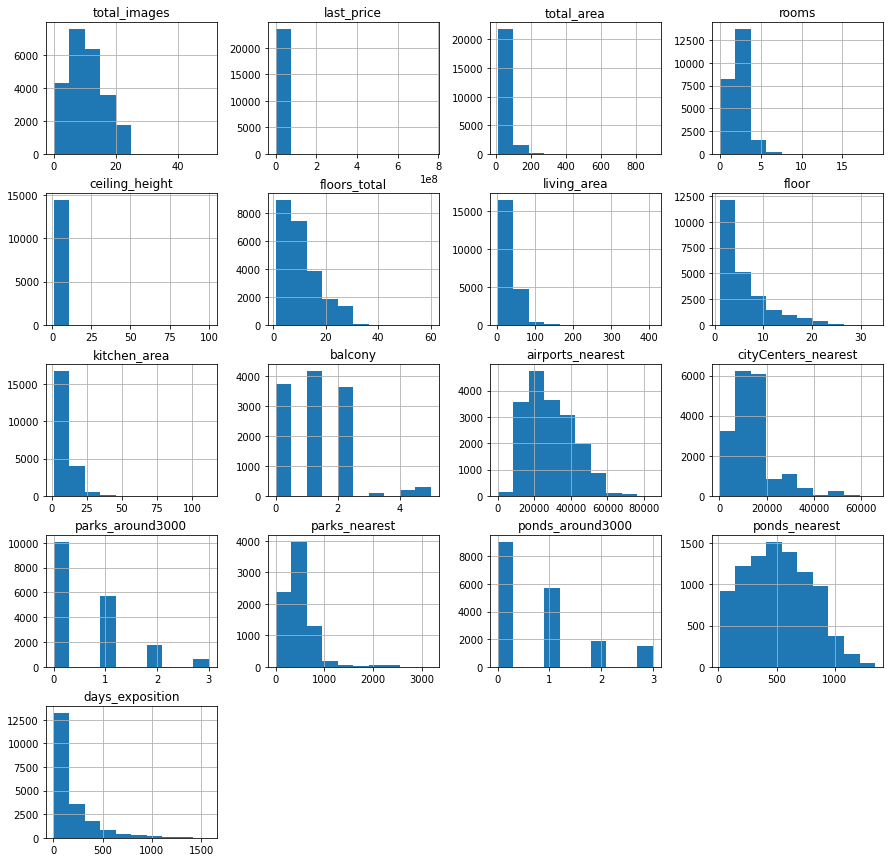

In [5]:
data.hist(figsize=(15,15));

### Предобработка данных

#### Работа с пропусками

Посмотрим, сколько пропущенных значений в каждом столбце.

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

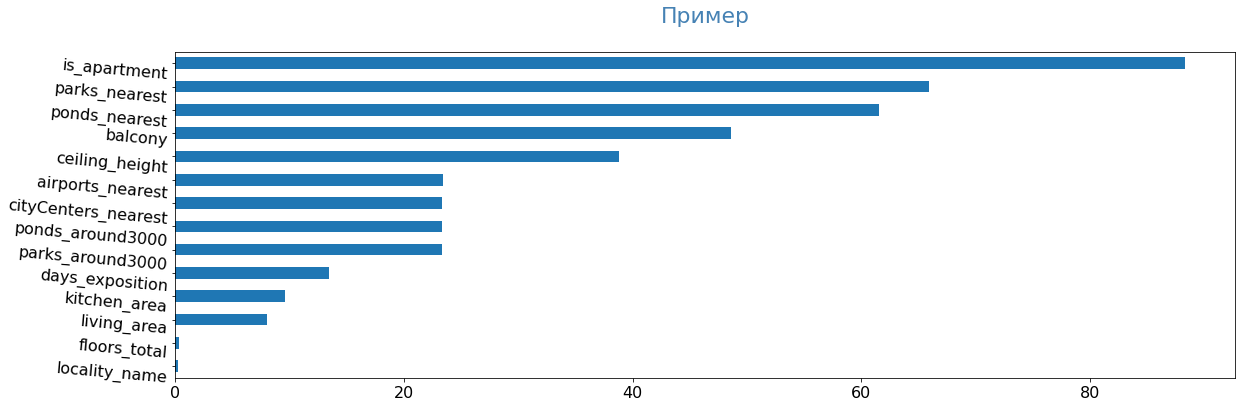

In [8]:
pass_value_barh(data)

Наибольшее количество нулевых значений встречается в столбце **is_apartment**. Данный столбец не используется в анализе, его можно удалить.

In [9]:
data = data.drop(columns='is_apartment')

Заменим пропуски в столбце **balcony** на нулевые значения: продавец вряд ли станет указывать в объявлении, что в квартире 0 балконов, однако этот параметр может пригодиться при анализе.

In [10]:
data['balcony'] = data['balcony'].fillna(0)

В столбцах **floors_total** и **locality_name** пропусков незначительное количество, такие строки можно просто отбросить.

In [11]:
data = data.dropna(subset=['floors_total', 'locality_name'])

Столбцы **parks_around3000** и **ponds_around3000** хранят количество парков и водоемов в радиусе 3 км соответственно и не используются в анализе. Эти столбцы можно удалить.

In [12]:
data = data.drop(columns=['parks_around3000', 'ponds_around3000'])

В столбце **ceiling_height** более 9 тысяч пропусков. Заполним пропуски в объектах недвижимости дешевле 15 млн рублей значением из [постановления Правительства РФ](https://www.consultant.ru/document/cons_doc_LAW_58136/85f7dc8994f991a1132725df3886eeefc605e1b9/). Минимальная высота потолка в жилых помещениях для Санкт-Петербурга и ЛО - 2,5 метра. Для объектов недвижимости дороже 15 млн рублей возьмем медианное значение [3 метра](https://sochi.cian.ru/stati-vysokie-potolki-za-i-protiv-312614/).

In [13]:
data.loc[data['last_price'] < 15000000, 'ceiling_height'] = (data.loc[data['last_price'] < 15000000,
                                                                      'ceiling_height'].fillna(2.5))
data.loc[data['last_price'] >= 15000000, 'ceiling_height'] = (data.loc[data['last_price'] >= 15000000,
                                                                       'ceiling_height'].fillna(3))

В столбце **living_area** заменим пропуски по следующему правилу: для непустых строк найдем коэффициент отношения средней площади к средней площади жилых помещений, а затем разделим общую площадь в строках с пропущенными значениями на этот коэффициент. Аналогичное правило заполнения пропусков применим к **kitchen_area**.

In [14]:
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [15]:
data['error_area'] = data['total_area']*0.9 <= (data['living_area']+data['kitchen_area'])
data.error_area.value_counts()

False    22908
True       657
Name: error_area, dtype: int64

При заполнении площадей синтетическими значениями было выявлено 657 аномалий. Такие аномалии были отбршены.

In [16]:
data = data.query('error_area == False')
data = data.drop(columns='error_area')

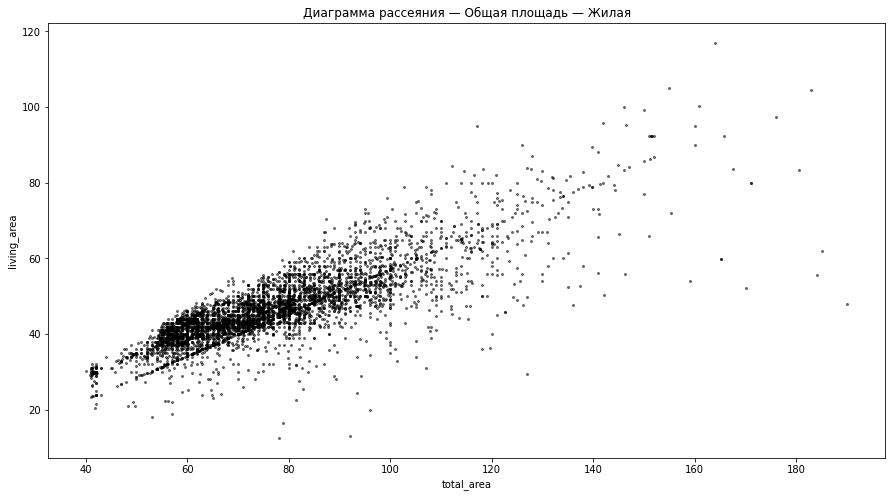

In [17]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

В столбце **days_exposition** пропуски могут быть вызваны тем, что на момент выгрузки датасета объявления были активны. Пропуски в оставшихся столбцах могут быть вызваны двумя факторами - человеческим и техническим. Продавцы могли не предоставить данные, например, если они не требовались в некоторых случаях. Также данные могли быть утрачены в результате некорректной загрузки-выгрузки данных или в процессе работы с таблицами. Столбцы **nearest** оставим как есть (в этих пропусках виноват человеческий фактор), заполнять или отбрасывать строки с такими пропусками не стоит.

#### Работа с типами данных

В некоторых столбцах датасета неверно указан тип данных. Например, столбец **floors_total**, хранящий общее количество этажей в доме, мог бы ограничиться типом данных **int**, т.к. количество этажей - натуральное число. Такая же ситуация со столбцом **balcony**.

In [18]:
data['floors_total'] = data['floors_total'].astype('int') 
data['balcony'] = data['balcony'].astype('int')

Также следует изменить тип данных в столбце **first_day_exposition** на **datetime**:

In [19]:
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Посмотрим на результаты:

In [20]:
data = data.reset_index(drop=True)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_nearest,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,482.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.50,11,18.600000,1,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,NaN,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.300000,4,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,90.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,3.00,14,90.816648,9,False,False,27.836861,0,Санкт-Петербург,28098.0,6800.0,84.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,112.0,48.0,121.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22908 entries, 0 to 22907
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22908 non-null  int64         
 1   last_price            22908 non-null  float64       
 2   total_area            22908 non-null  float64       
 3   first_day_exposition  22908 non-null  datetime64[ns]
 4   rooms                 22908 non-null  int64         
 5   ceiling_height        22908 non-null  float64       
 6   floors_total          22908 non-null  int64         
 7   living_area           22908 non-null  float64       
 8   floor                 22908 non-null  int64         
 9   studio                22908 non-null  bool          
 10  open_plan             22908 non-null  bool          
 11  kitchen_area          22908 non-null  float64       
 12  balcony               22908 non-null  int64         
 13  locality_name   

#### Обработка дубликатов

Проверим таблицу для начала на наличие явных дубликатов.

In [22]:
data.duplicated().value_counts()

False    22908
dtype: int64

Явных дубликатов нет. Следует проверить единственный категориальный параметр **locality_name** на наличие неявных дубликатов.

In [23]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [24]:
len(data['locality_name'].unique())

362

Обнаруженные дубликаты возникли из-за различного написания слова "поселок" или буквы "ё", это можно исправить.

In [25]:
locality_names = []
for name in data['locality_name']:
    name = name.replace('посёлок','поселок')
    name = name.replace('посёлок городского типа', 'поселок')
    name = name.replace('поселок городского типа', 'поселок')
    name = name.replace('коттеджный посёлок','поселок')
    name = name.replace('коттеджный поселок','поселок')
    name = name.replace('городской посёлок','поселок')
    name = name.replace('городской поселок','поселок')
    name = name.replace('ё', 'е')
    locality_names.append(name)

data['locality_name'] = pd.Series(locality_names)

In [26]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

In [27]:
data.locality_name.nunique()

319

Вместо 364 уникальных значений - 321.

#### Обработка аномальных значений

Для обнаружения аномальных значений удобнее всего взглянуть на данные поближе - в виде графиков.

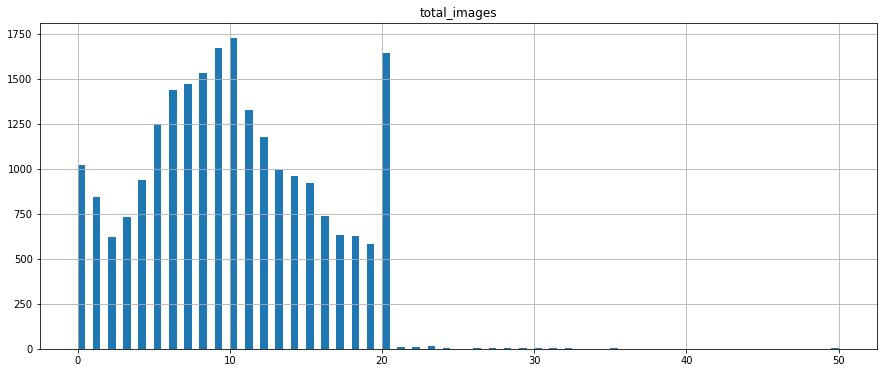

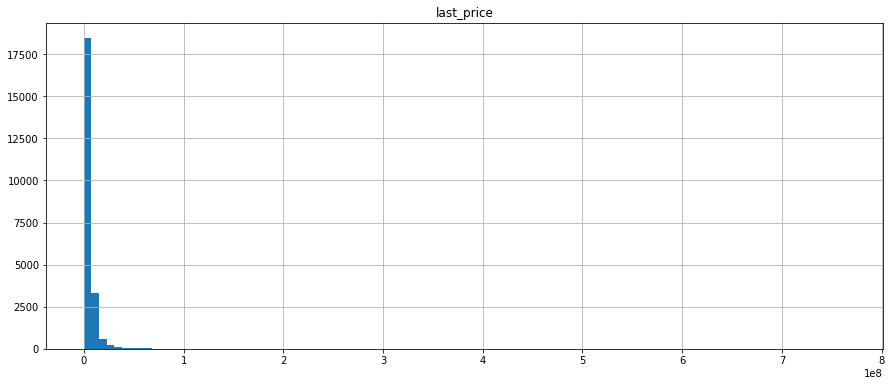

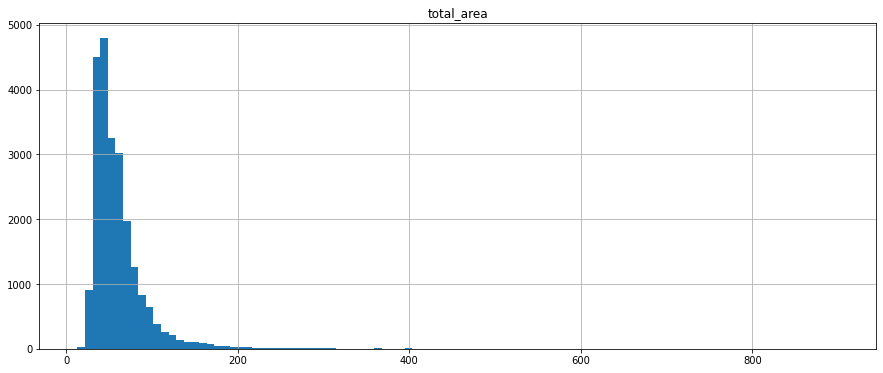

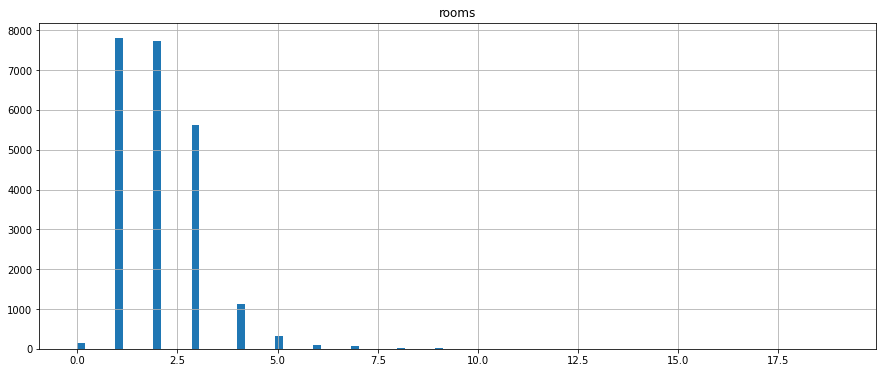

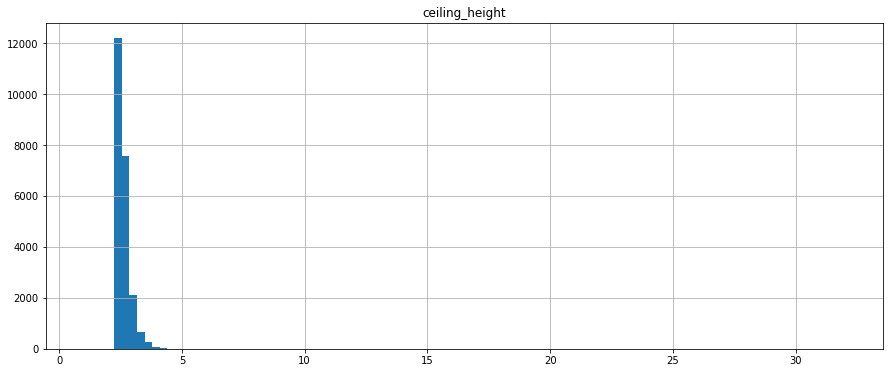

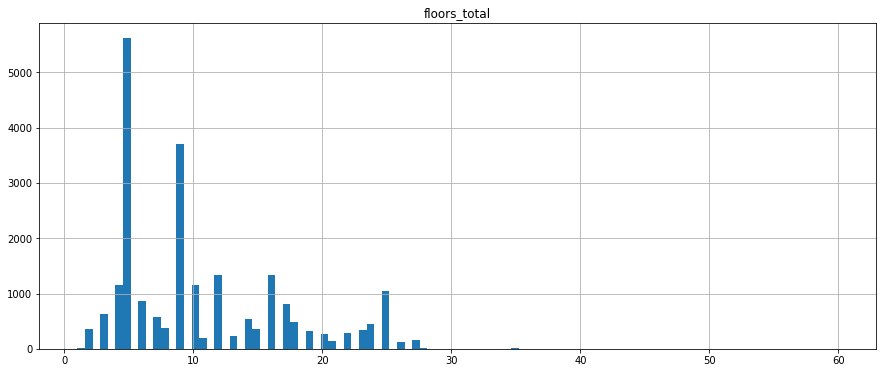

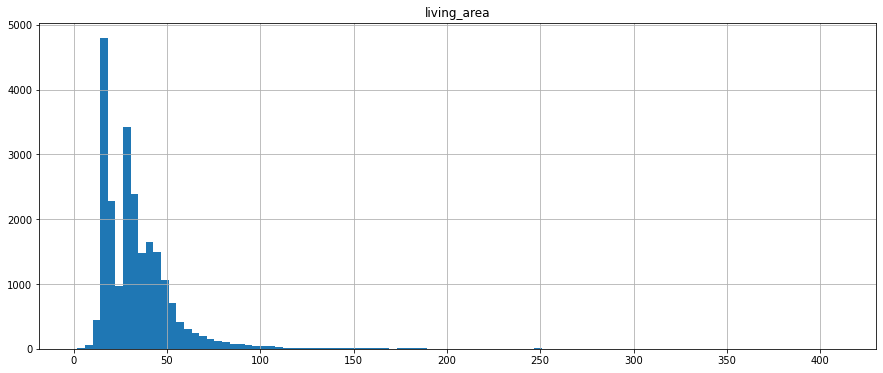

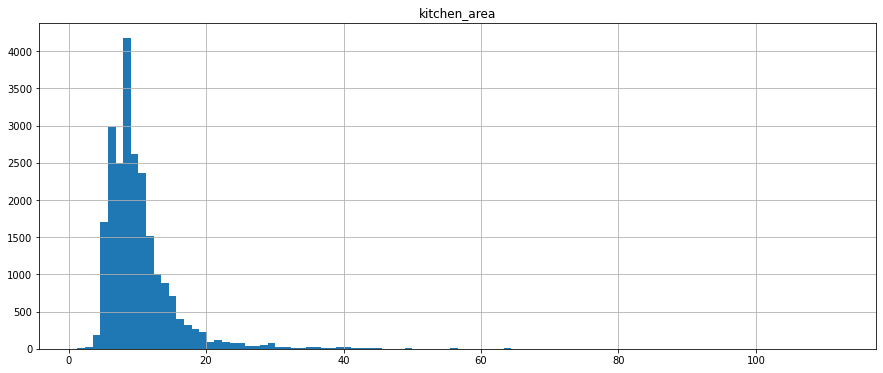

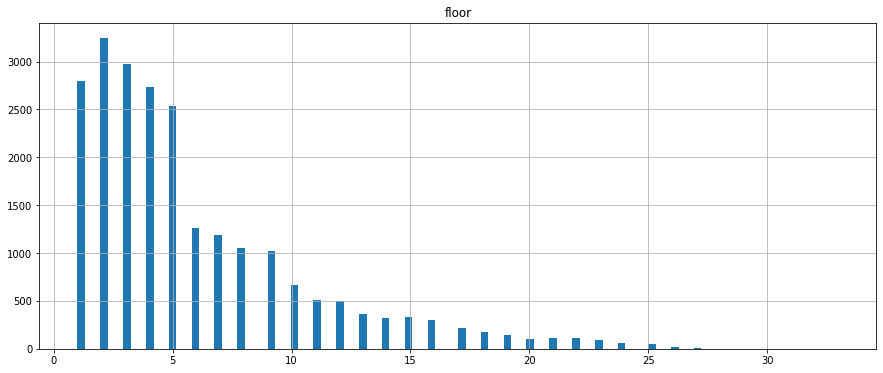

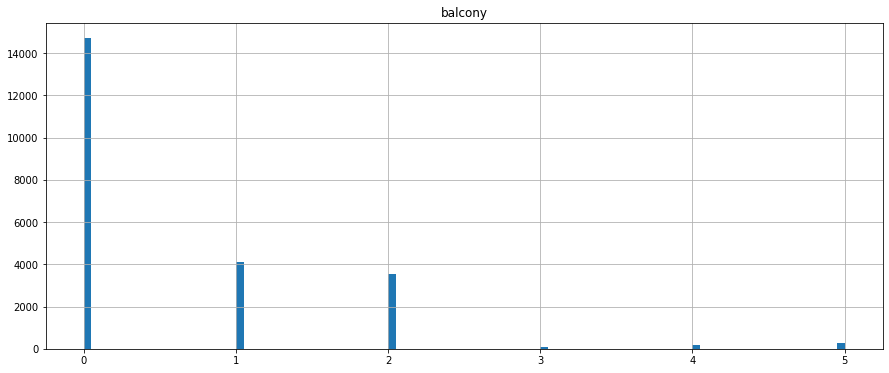

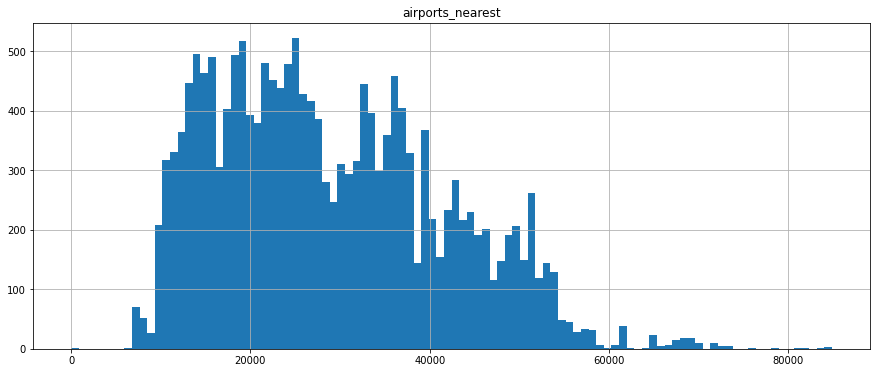

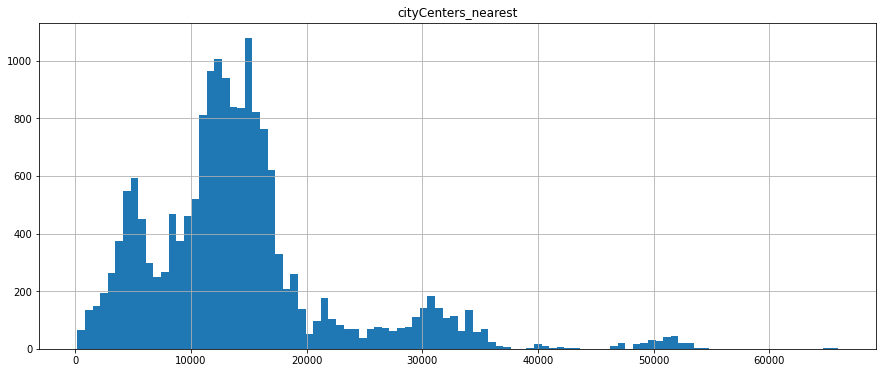

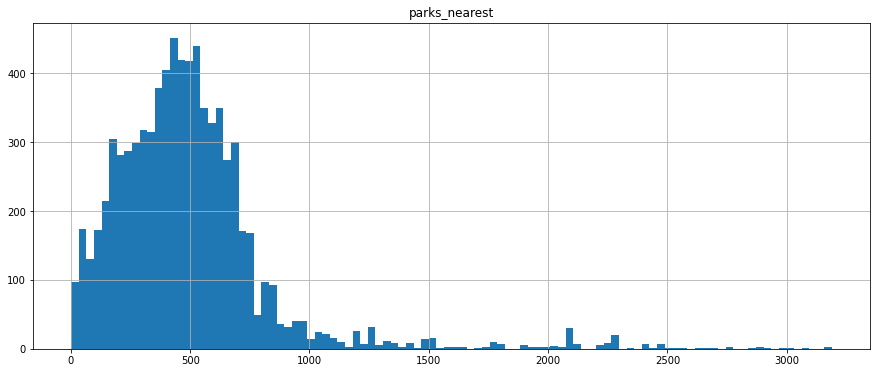

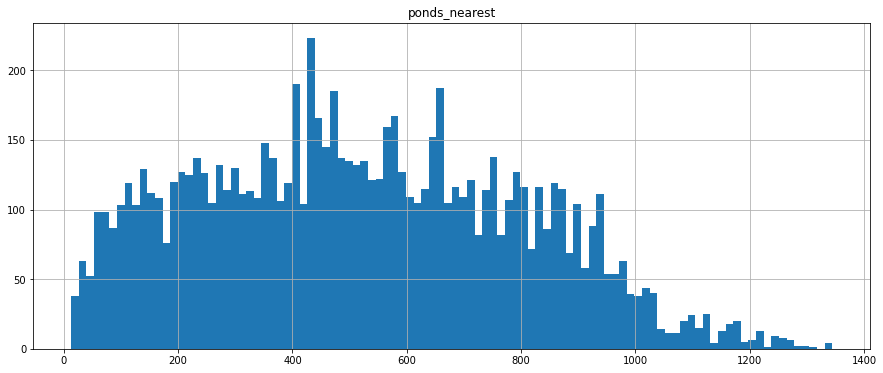

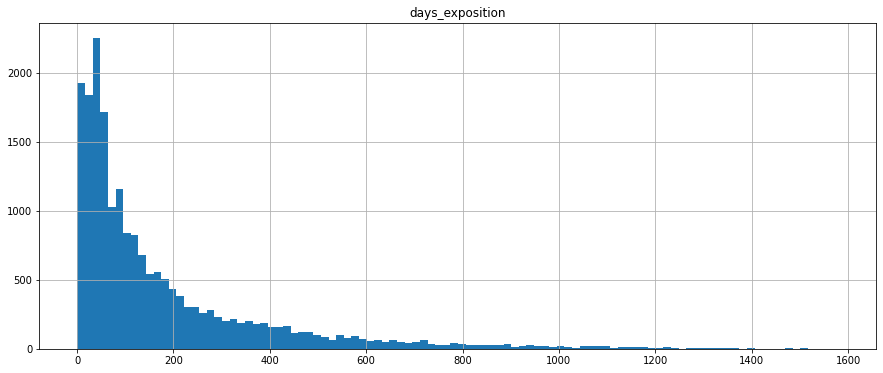

In [28]:
for col in ['total_images', 'last_price', 'total_area',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'floor', 'balcony',
       'airports_nearest', 'cityCenters_nearest', 'parks_nearest',
       'ponds_nearest', 'days_exposition']:
    data.hist(col, bins=100, figsize=(15,6))

In [29]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,21.40,2.40,3.00,"562,442.00",9.44,3.31,1.00,2.00
0.01,1.00,27.00,2.50,4.00,"1,010,700.00",13.00,4.62,1.00,2.00
0.5,2.00,52.00,2.50,95.00,"4,630,000.00",30.00,9.00,4.00,9.00
0.99,5.00,196.00,3.60,"1,069.66","35,099,510.00",117.40,35.00,23.00,26.00
0.9988,8.00,389.21,5.55,"1,365.60","124,416,508.00",226.92,61.02,26.00,34.51


Среди всех оторванных от графиков значений наиболее странно выглядит высота потолков в 25 метров. Следует рассмотреть столбец **ceiling_height** на предмет аномальных значений.

Высота потолков 14 метров - круто, но 20 - совсем не похоже на правду. Встречается множество квартир с высотой потолков больше 20 метров. Также следует избавиться от неправдоподобно малых значений высоты потолков.

In [30]:
data = data.query('ceiling_height >= 2.4 and ceiling_height <= 4')

Во многих столбцах встречаются **крайне редкие значения**. От таких значений лучше избавиться, так как они требуют отдельной обработки.

In [31]:
data = data.query('rooms <= 5')
data = data.query('total_area >= 20 and total_area < 200')
data = data.query('floors_total <= 26 and floors_total > 0')
data = data.query('living_area > 10 and living_area <= 122')
data = data.query('kitchen_area <= 35.5')
data = data.query('last_price <= 40000000')
data = data.query('days_exposition <= 1100 or days_exposition.isna()')

#### check gap

In [32]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21903 entries, 0 to 22907
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21903 non-null  int64         
 1   last_price            21903 non-null  float64       
 2   total_area            21903 non-null  float64       
 3   first_day_exposition  21903 non-null  datetime64[ns]
 4   rooms                 21903 non-null  int64         
 5   ceiling_height        21903 non-null  float64       
 6   floors_total          21903 non-null  int64         
 7   living_area           21903 non-null  float64       
 8   floor                 21903 non-null  int64         
 9   studio                21903 non-null  bool          
 10  open_plan             21903 non-null  bool          
 11  kitchen_area          21903 non-null  float64       
 12  balcony               21903 non-null  int64         
 13  locality_name   

In [33]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',
          'kitchen_area', 'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,903.00","21,903.00","21,903.00","19,012.00","21,903.00","21,903.00","21,903.00","21,903.00","21,903.00"
min,0.00,20.00,2.40,1.00,"430,000.00",10.08,1.30,1.00,1.00
max,5.00,199.20,4.00,"1,100.00","40,000,000.00",122.00,35.50,26.00,26.00
median,2.00,51.10,2.50,93.00,"4,590,000.00",30.00,9.00,4.00,9.00


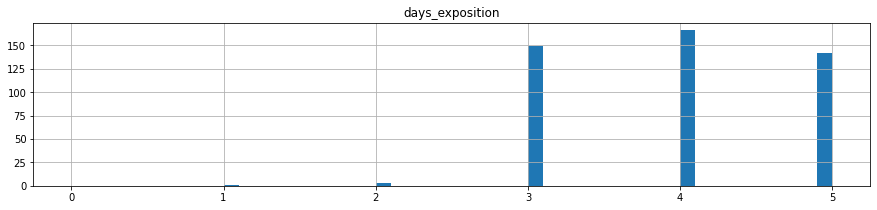

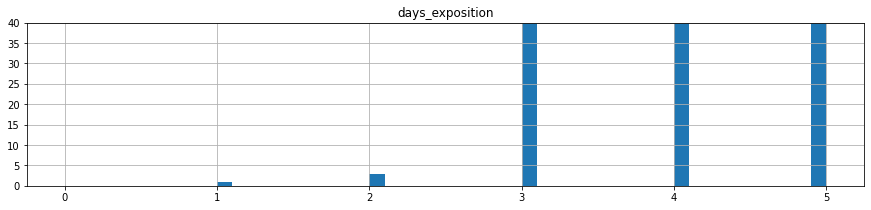

In [34]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [35]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7569
2,7539
3,5414
4,1025
5,225
0,131


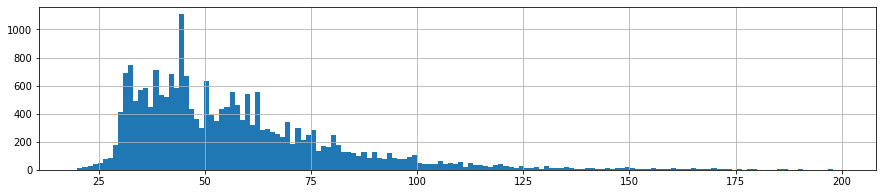

In [36]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

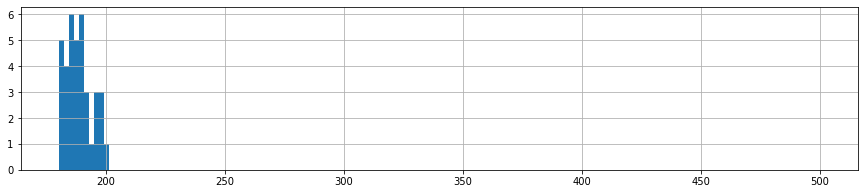

In [37]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

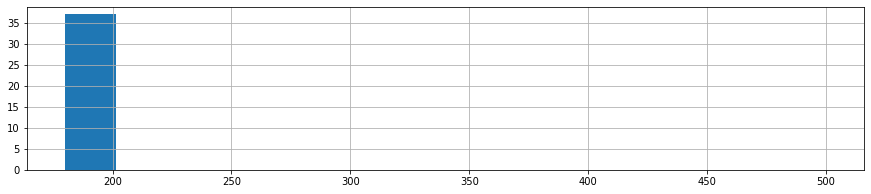

In [38]:
# check
data.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

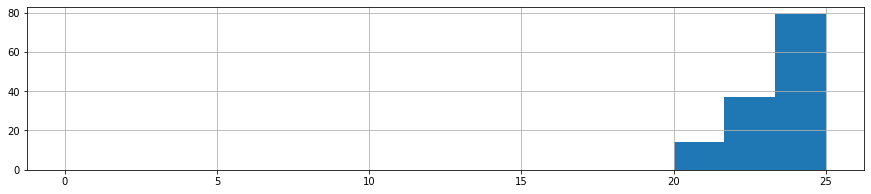

In [39]:
# check
data.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [40]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,22.00,2.45,3.00,"569,236.00",11.00,3.76,1.00,2.00
0.01,1.00,27.00,2.50,4.00,"1,000,000.00",13.56,4.73,1.00,2.00
0.5,2.00,51.10,2.50,93.00,"4,590,000.00",30.00,9.00,4.00,9.00
0.99,5.00,147.00,3.50,924.00,"23,000,000.00",88.00,26.00,22.00,25.00
0.9988,5.00,185.00,3.99,"1,079.19","35,858,800.00",111.46,34.00,25.00,26.00


### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец **meter_price** - цена за квадратный метр.

In [41]:
data['meter_price'] = data['last_price']/data['total_area']

Добавим столбец **post_weekday** - день недели публикации.

In [42]:
data['post_weekday'] = data['first_day_exposition'].dt.day_of_week

Добавим столбец **post_month** - месяц публикации и столбец **post_year** - год публикации.

In [43]:
data['post_month'] = data['first_day_exposition'].dt.month
data['post_year'] = data['first_day_exposition'].dt.year

Добавим столбец **floor_type** - первый, последний или "другой" этаж.

In [44]:
def floor_typed(x):
    if x['floor'] == 1:
        return 'первый'
    elif x['floor'] == x['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_typed, axis=1)

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Функция хорошая, стоит учесть крайние условия: нулевые и отрицательные значения        

Добавим столбец **cityCenters_nearest_km** - рассотяние до центра города в километрах.

In [45]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(decimals=0)

### Проведите исследовательский анализ данных

#### Изучение отдельных параметров

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

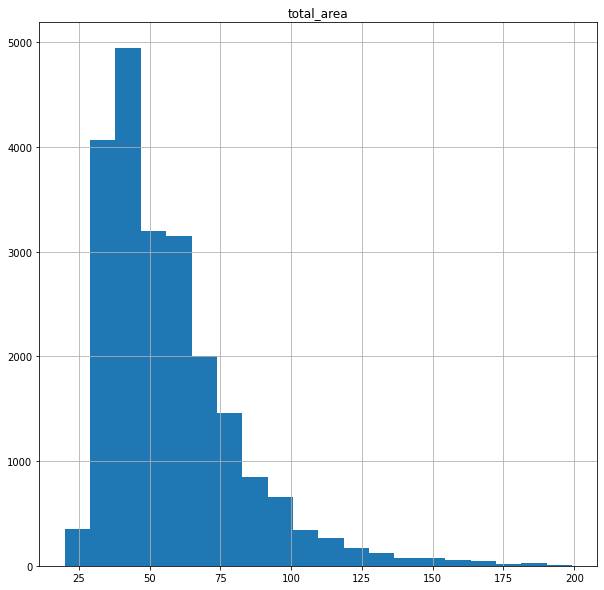

In [46]:
data.hist('total_area', bins=20, figsize=(10,10))

**Общая площадь** продаваемых квартир в более чем половине случаев менее 60 квадратных метров, предложение квартир с площадью более 200 кв. метров очень небольшое на данном рынке. Более 8000 квартир имеют площадь от 50 до 100 кв. метров.

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

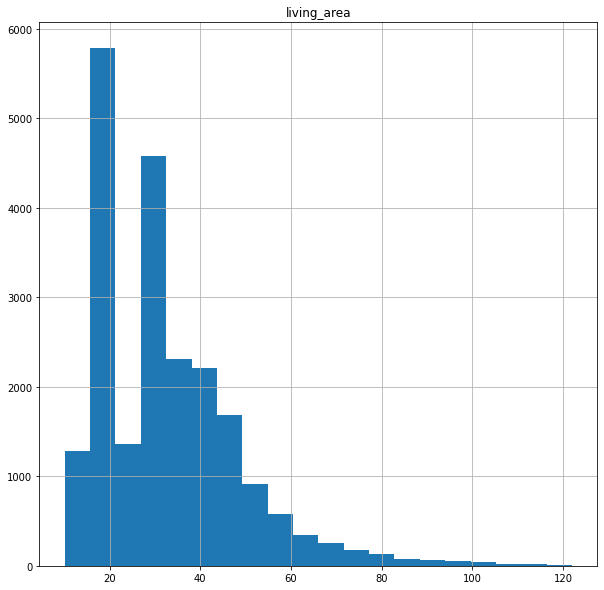

In [47]:
data.hist('living_area', bins=20, figsize=(10,10))

В большей части квартир **жилая площадь** - около 30 кв. метров, затем, чем больше жилая площадь, тем меньше становится таких предложений. Существует *отдельная категория квартир с жилой площадью более 250 метров.*

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

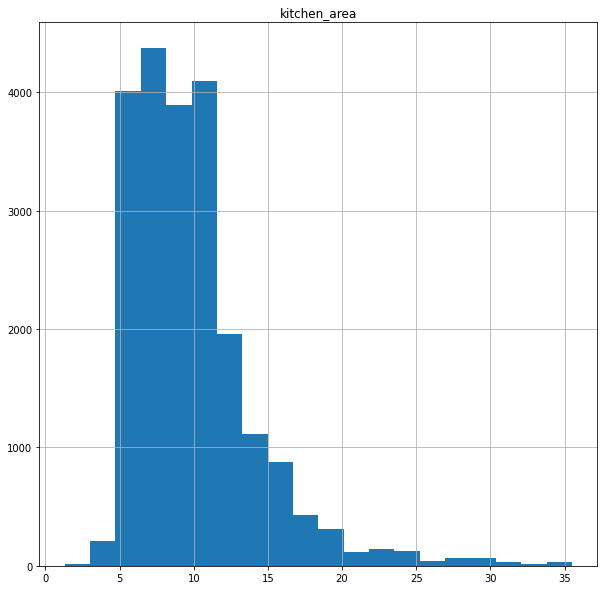

In [48]:
data.hist('kitchen_area', bins=20, figsize=(10,10))

В большинстве случаев, **площадь кухни** всего 10 квадратных метров. В примерно пяти тысячах квартир площадь кухни менее 10 кв. метров. Самые большие кухни, представленные в датасете - площадью между 60 и 70 квадратными метрами.

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

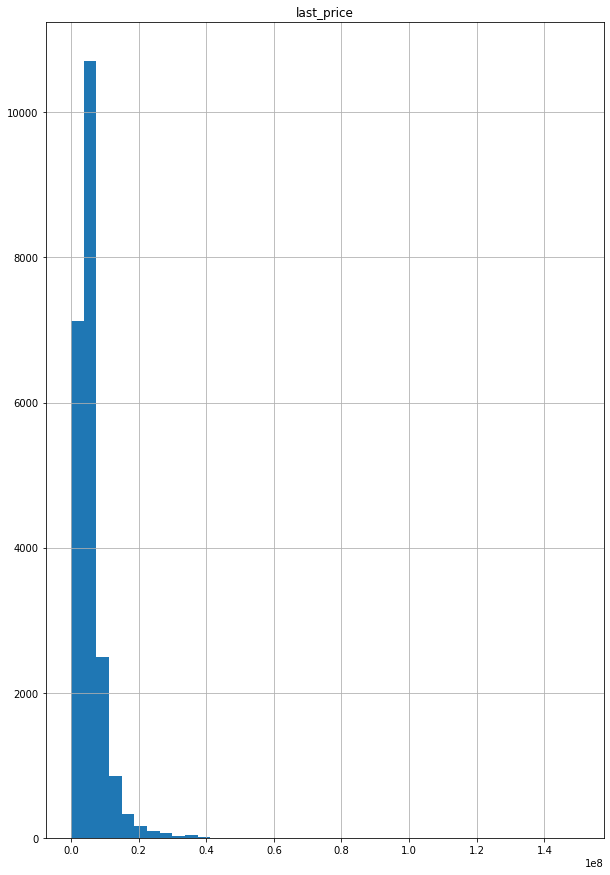

In [49]:
data.hist('last_price', bins=40, figsize=(10,15), range=(0,150000000))

Большая часть квартир имеет **цену** 7 млн и менее. Предложений с ценой выше 40 млн очень мало, однако максимальная цена квартиры - около 130 млн.

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

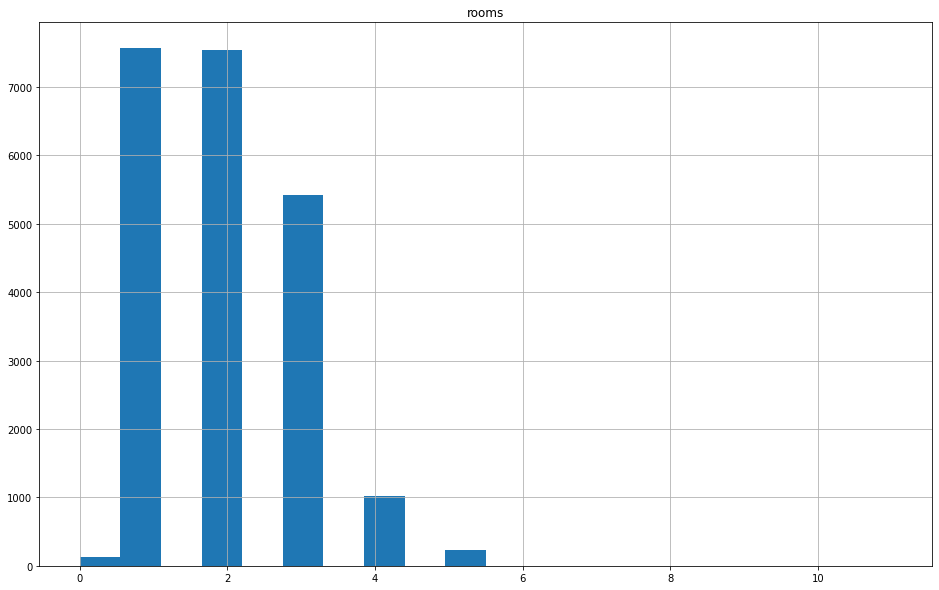

In [50]:
data.hist('rooms', bins=20, figsize=(16,10), range=(0,11))

Судя по графику, большая часть объектов - однокомнатные, максимальное количество **комнат**, встреченное в датасете - 9.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

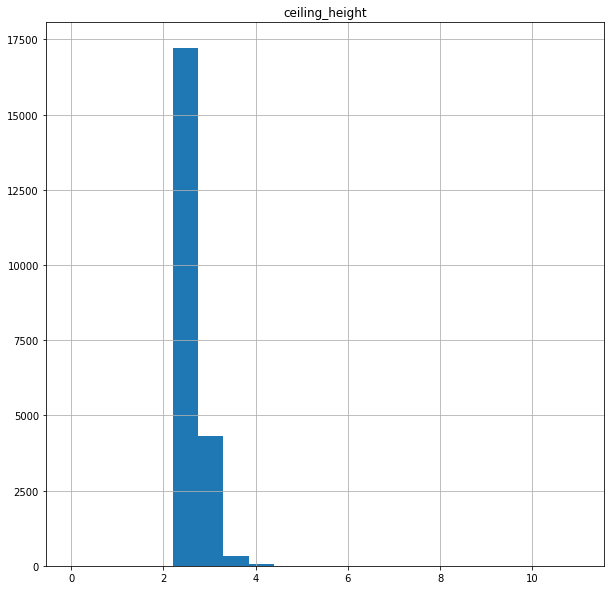

In [51]:
data.hist('ceiling_height', bins=20, figsize=(10,10), range=(0,11))

Судя по графику, замена пропусков на значение 2,5 метра не сильно повлияла на тенденцию - большая часть объектов имеет высоту потолков примерно от 2 до 3 метров.

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

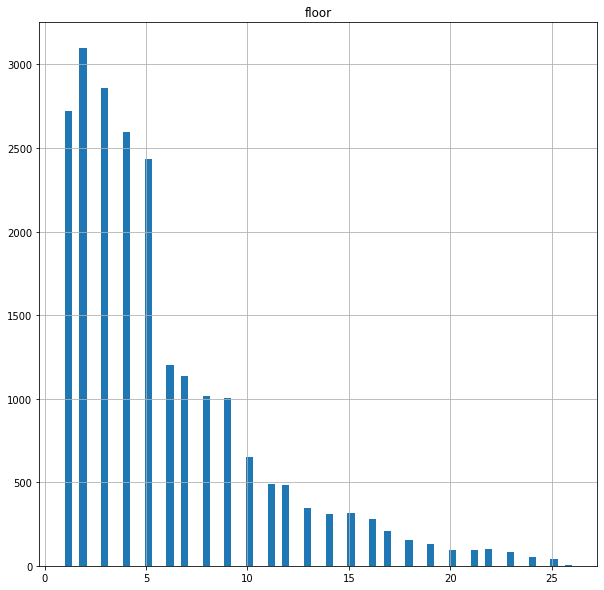

In [52]:
data.hist('floor', bins=70, figsize=(10,10))

Большая часть объектов расположена на 5 этаже или ниже. Квартиры на 25 этаже и выше можно считать редкими

In [53]:
data['floor_type'].value_counts()

другой       16139
последний     3044
первый        2720
Name: floor_type, dtype: int64

Вывод функции **value_counts** говорит сам за себя. Большая часть квартир находятся ни на первом, ни на последнем этаже. Любопытно, что количества объектов на первых и последних этажах близки друг к другу.

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

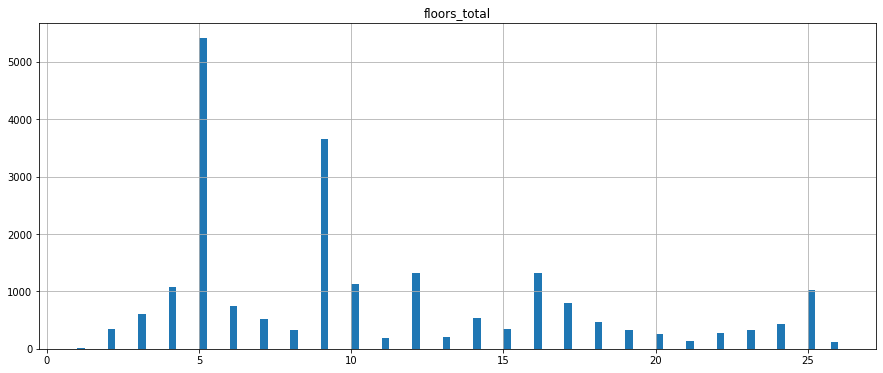

In [54]:
data.query('floors_total <= 35').hist('floors_total', bins=100, figsize=(15,6))

Судя по графику, пятиэтажных и девятиэтажных домов - больше всего(можно предположить, что это типовые дома советской застройки). Существует маленький пик в области 35-этажных домов, однако реже всего встречаются дома с 30 и более этажей.

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

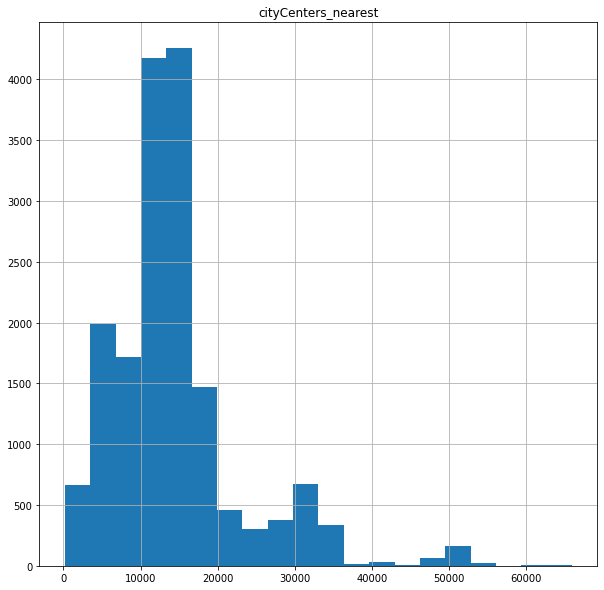

In [55]:
data.hist('cityCenters_nearest', bins=20, figsize=(10,10))

Большая часть объектов находится на удалении примерно в 20 километров от центра города. Также присутствует неожиданный пик на расстоянии от 50 до ~53 километров.

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

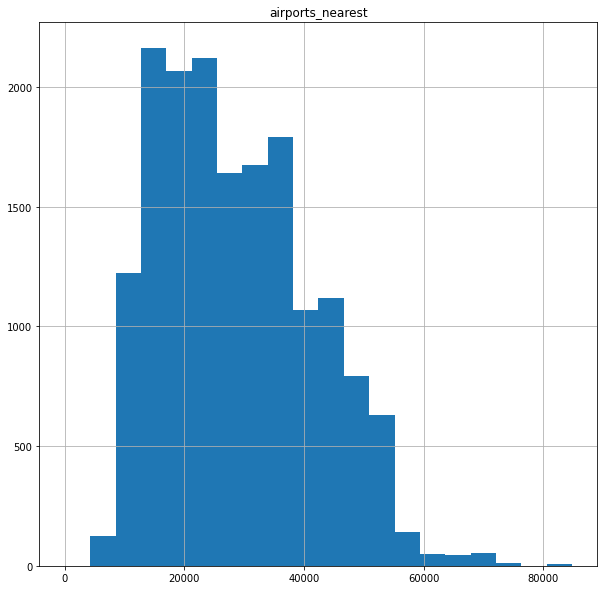

In [56]:
data.hist('airports_nearest', bins=20, figsize=(10,10))

Необычные скопления объектов на расстоянии ~80 километров. Основная масса объектов удалена от аэропорта менее, чем на 40 километров.

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

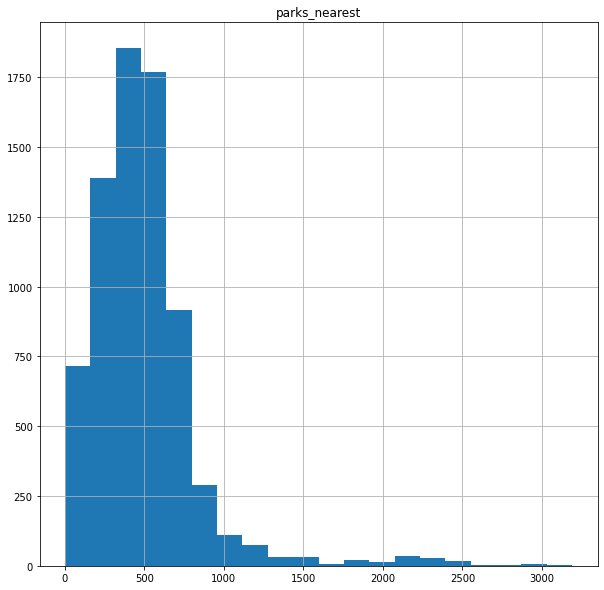

In [57]:
data.hist('parks_nearest', bins=20, figsize=(10,10))

Большая часть объектов расположена не более чем в километре от парка. Максимальное расстояние до парка - ~3 километра, но таких оюъектов очень мало.

array([[<AxesSubplot:title={'center':'post_weekday'}>]], dtype=object)

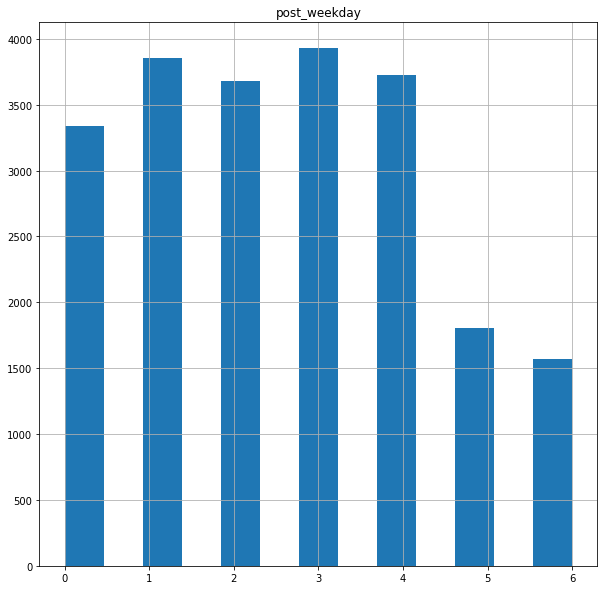

In [58]:
data.hist('post_weekday', bins=13, figsize=(10,10))

Больше всего объявлений выложены в четверг. На втором месте - вторник. Меньше всего объявлений выкладывают по воскресеньям и субботам.

array([[<AxesSubplot:title={'center':'post_month'}>]], dtype=object)

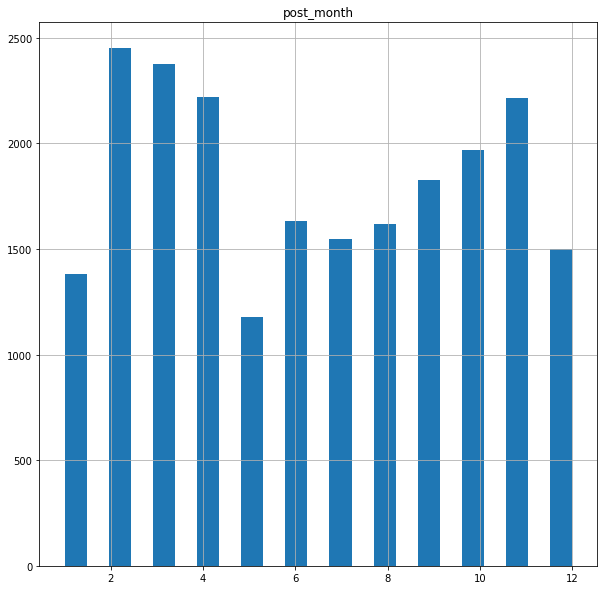

In [59]:
data.hist('post_month', bins=23, figsize=(10,10))

Большая часть объявлений приходится на февраль, март и апрель. Меньше всего объявлений выкладывается в январе и в мае. Любопытно, почему февраль, будучи самым коротким месяцем, опережает все остальные месяцы.

#### Изучение сроков снятия объявлений

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

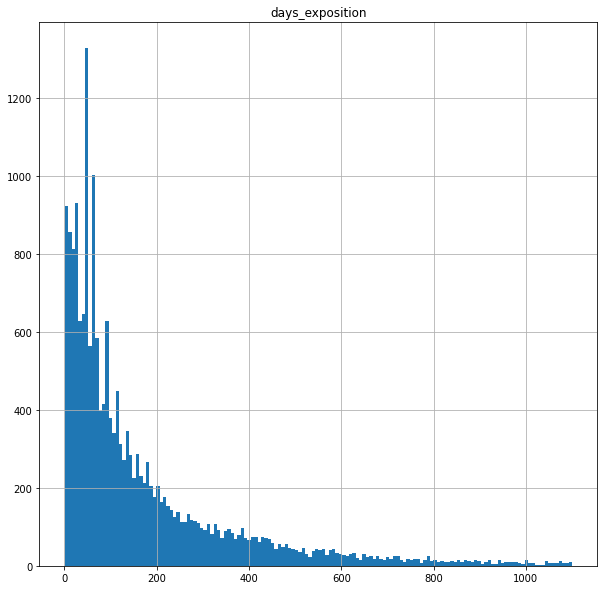

In [60]:
data.hist('days_exposition', bins=150, figsize=(10,10))

В целом, график количества дней публикации подчиняется законам нормального распределения, однако существует пик на значениях ~70 дней. Максимально долгие объявления находились на платформе до 1600 дней (около 4,5 лет). Посчитаем среднее значение и медиану для данной метрики.

In [61]:
data['days_exposition'].mean()

170.6282873974332

Среднее - 180,7 дней

In [62]:
data['days_exposition'].median()

93.0

Медианное значение почти в 2 раза меньше! Всего 95 дней.

#### Изучение зависимостей цены объекта от других факторов

In [63]:
data['last_price'] = data['last_price'] / 1000000
data['last_price']

0        13.000
1         3.350
2         5.196
5         2.890
6         3.700
          ...  
22903     9.700
22904     3.100
22905     2.500
22906    11.475
22907     1.350
Name: last_price, Length: 21903, dtype: float64

Теперь цены объектов указаны в миллионах рублей. Сделаем так для удобства отображения на графиках.

Рассмотрим **зависимость цены объекта от общей площади**. Для того, чтобы можно было делать выводы, диаграмму рассеяния необходимо укрупнить(так же и для других графиков). Воспользуемся для этого методом query() и отбросим единичные значения площади и цены.

In [ ]:
(data.pivot_table(index='total_area', values='last_price', aggfunc='median')
     .reset_index().query('(total_area < 200) & (last_price < 30)')
     .plot(x='total_area', y='last_price', kind='scatter', figsize=(20,15), alpha=0.4) 
);

На графике видно, что значения цен для одной площади до 75 кв. метров достаточно близки, относительно больших площадей. Диапазон цен с ростом площади укрупняется в несколько раз. Посмотрим, как коррелируют эти величины.

In [65]:
data['last_price'].corr(data['total_area'])

0.765218983143507

Данный коэффициент корреляции соответствует прямой средней статистической зависимости.

Рассмотрим **зависимость цены от жилой площади**

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

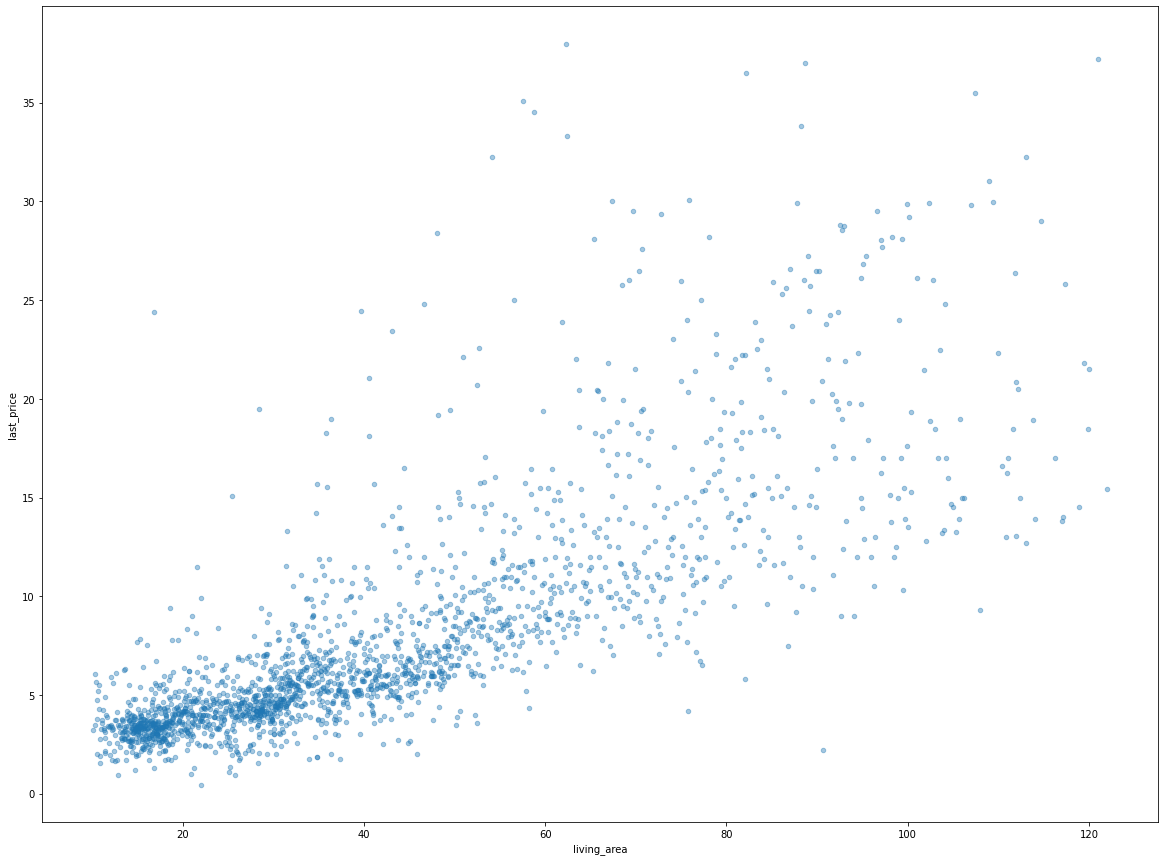

In [66]:
(data.pivot_table(index='living_area', values='last_price', aggfunc='median')
     .reset_index().query('(living_area < 200) & (last_price < 70)')
     .plot(x='living_area', y='last_price', kind='scatter', figsize=(20,15), alpha=0.4) 
)

In [67]:
data['last_price'].corr(data['living_area'])

0.6668352092786748

Данный коэффициент корреляции соответствует средней прямой статистической зависимости.

Рассмотрим **зависимость цены от площади кухни**

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

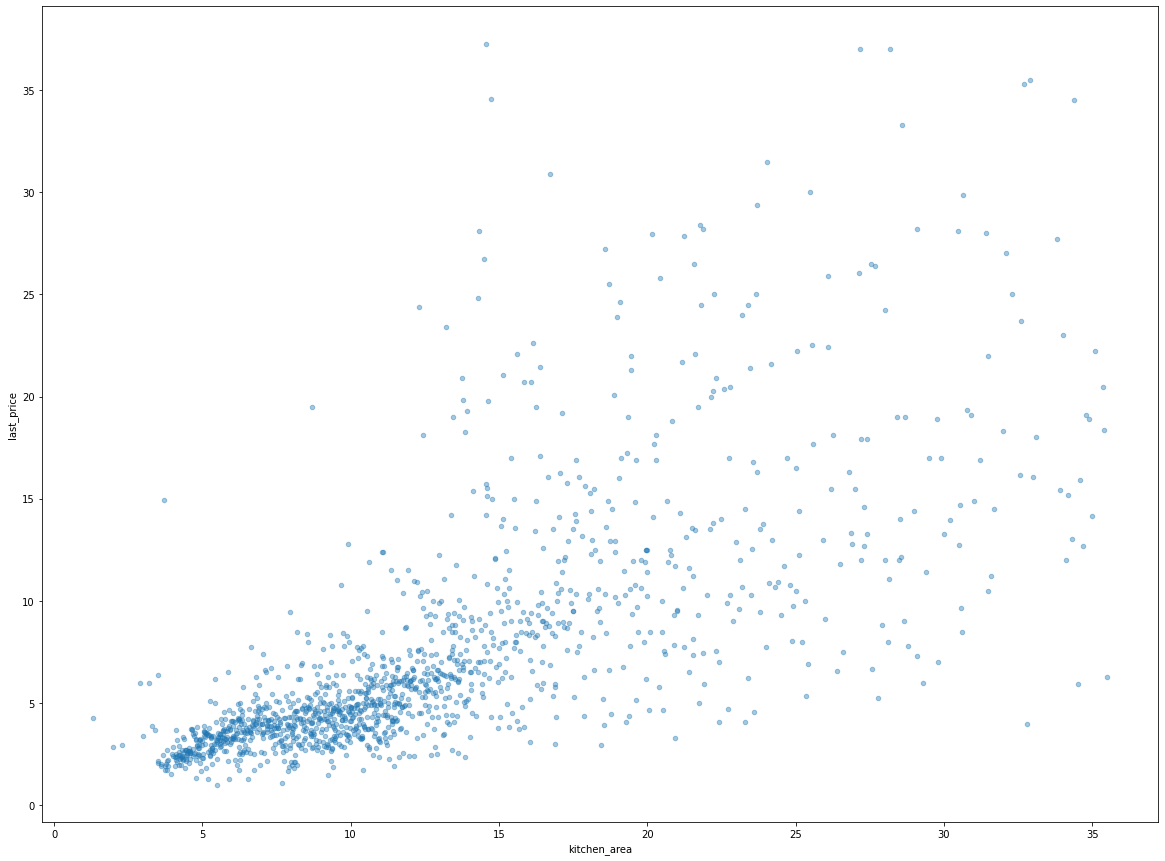

In [68]:
(data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
     .reset_index().query('(kitchen_area < 40) & (last_price < 70)')
     .plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(20,15), alpha=0.4) 
)

In [69]:
data['last_price'].corr(data['kitchen_area'])

0.5930992510925125

Данный коэффициент корреляции соответствует средней прямой статистической зависимости.

Рассмотрим **зависимость цены от количества комнат**

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

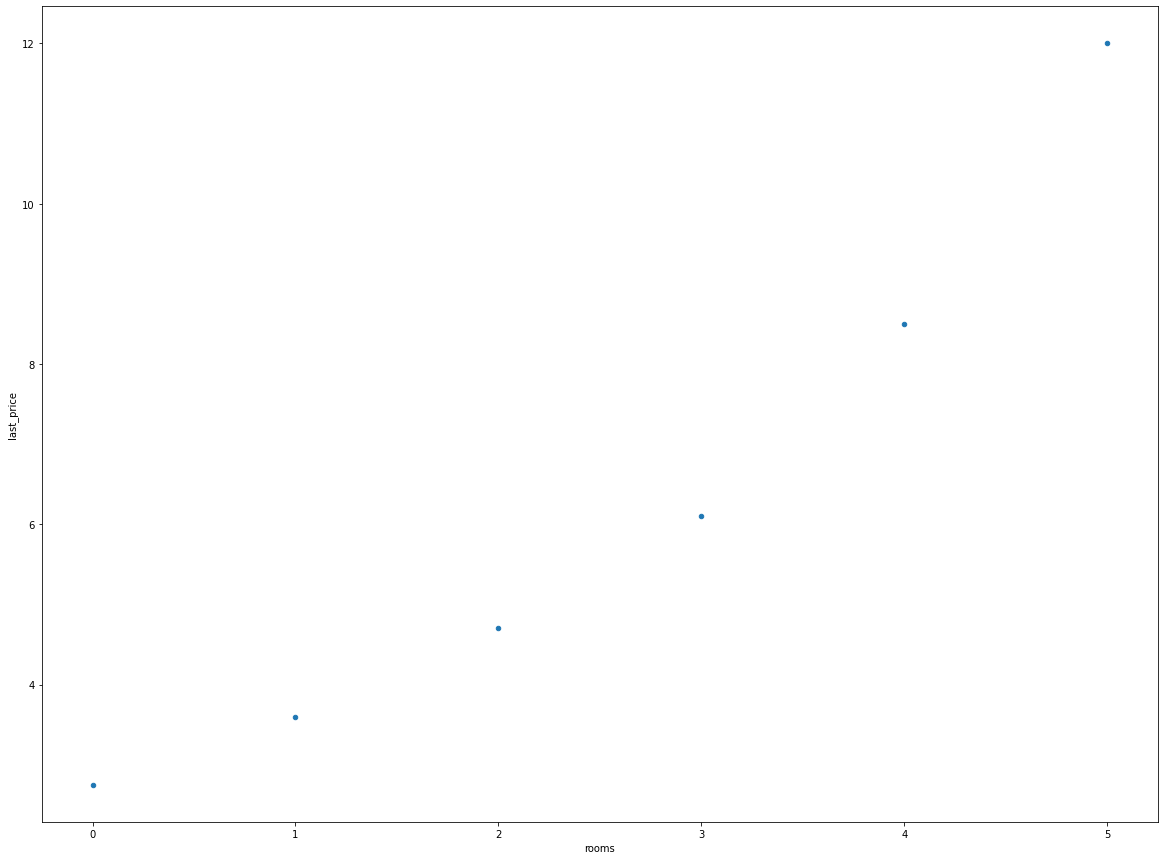

In [70]:
(data.pivot_table(index='rooms', values='last_price', aggfunc='median')
     .reset_index().query('(last_price < 70)')
     .plot(x='rooms', y='last_price', kind='scatter', figsize=(20,15)) 
)

In [71]:
data['last_price'].corr(data['rooms'])

0.4646602575496829

При количестве комнат до 7 включительно, медианное значение цены возрастает. Провал в цене наблюдается среди 8-, 9-, 10-комнатных квартир, однако, начиная с 11-комнатных квартир, медианное значение цены растет. Выбросы медианного значения цены, например, 15-комнатных квартир могут быть вызваны малым количеством предложений на рынке. Стоит отметить, что коэффициент корелляции указывает на **слабую** статистическую зависимость.

Рассмотрим **зависимость цены от типа этажа**

<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

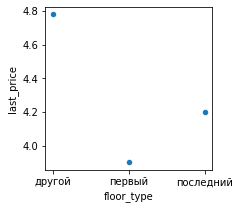

In [72]:
(data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
     .reset_index()
     .plot(x='floor_type', y='last_price', kind='scatter', figsize=(3,3)) 
)

Судя по графику, медианное значение цен объектов, расположенных на этажах категории "другой"(т.е. не первый и не последний), выше, чем у двух других категорий. Меньше всего медианное значение цен квартир на первых этажах.

Рассмотрим **зависимость цены от дня, месяца и года публикации объявления**

<AxesSubplot:xlabel='post_weekday', ylabel='last_price'>

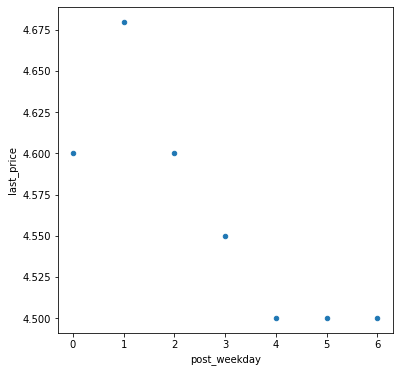

In [73]:
(data.pivot_table(index='post_weekday', values='last_price', aggfunc='median')
     .reset_index()
     .plot(x='post_weekday', y='last_price', kind='scatter', figsize=(6,6)) 
)

Исходя из графика, составим рейтинг дней по убыванию медианной цены квартир:
1. Вторник
2. Среда
3. Понедедельник, Четверг
4. Пятница, Суббота
5. Воскресенье

<AxesSubplot:xlabel='post_month', ylabel='last_price'>

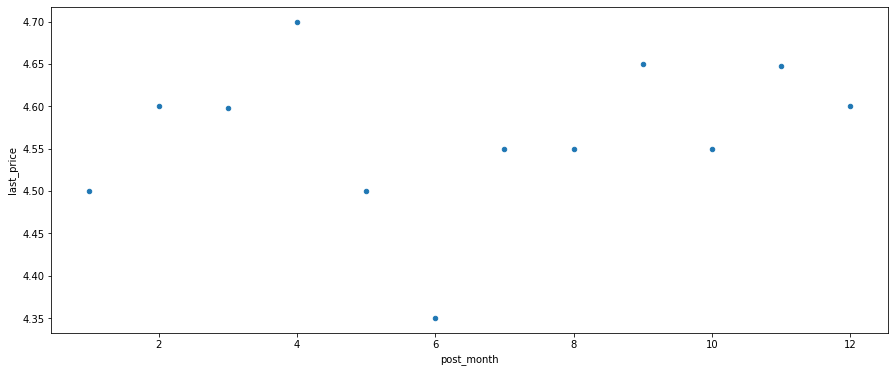

In [74]:
(data.pivot_table(index='post_month', values='last_price', aggfunc='median')
     .reset_index()
     .plot(x='post_month', y='last_price', kind='scatter', figsize=(15,6)) 
)

Составим также рейтинг месяцов по убыванию медианной цены:
1. Апрель
2. Сентябрь, Ноябрь
3. Декабрь
4. Февраль, Март, Июль
5. Январь
6. Август, Октябрь
7. Май
6. Июнь

<AxesSubplot:xlabel='post_year', ylabel='last_price'>

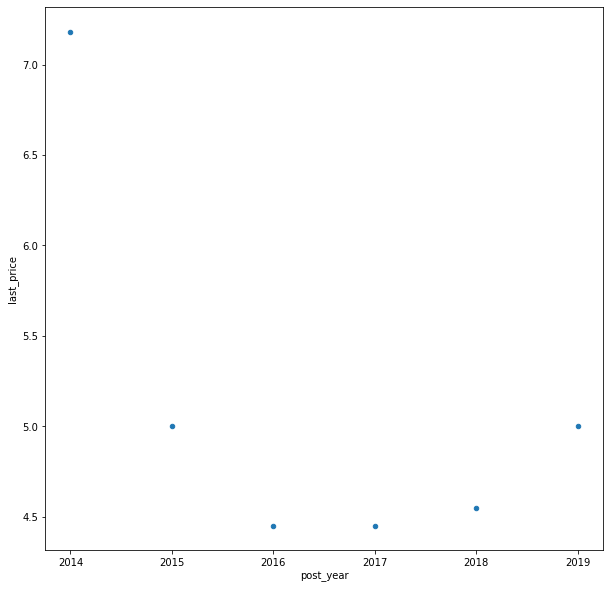

In [75]:
(data.pivot_table(index='post_year', values='last_price', aggfunc='median')
     .reset_index()
     .plot(x='post_year', y='last_price', kind='scatter', figsize=(10,10)) 
)

Аналогично, составим рейтинг с убыванием медианной цены по годам:
1. 2014
2. 2015
3. 2019
4. 2018
5. 2016
6. 2017

Можно сказать, что медианная цена квартир почему-то сильно упала в 2016-17 годах и с 2018 начала расти... хм

In [76]:
years_pivot = data.pivot_table(index='post_year', values = ['last_price','total_area'], \
                               aggfunc=['count', 'median'])
years_pivot.columns = ['Количество объявлений','Лишнее','Медианная цена','Медианная площадь']
years_pivot.drop(columns='Лишнее')

,Количество объявлений,Медианная цена,Медианная площадь
post_year,,,
2014,90,7.1825,73.75
2015,954,5.0000,57.10
2016,2559,4.4500,52.40
2017,7648,4.4500,51.00
2018,7976,4.5500,50.20
2019,2676,5.0000,51.20


Судя по таблице, данные о цене за 2014 год основаны на маленькой выборке, поэтому они так выделяются на фоне других лет.

**Подводя итог,** можно сказать, что стоимость объекта зависит от площади больше всего. Также стоит отметить, что квартиры на первых этажах значительно дешевле, чем другие квартиры. Зависимость цены от дня и месяца публикации - нечто абстрактное, но вот при наблюдении графика по году публикации объявления, можно обнаружить, что самые дорогие объекты были опубликованы в 2015 и 2019 году, а самые дешевые (по медиане) - в 2016 и 2017. С 2017 по 2019 наблюдается рост медианной цены объектов.

#### Цены и населенные пункты

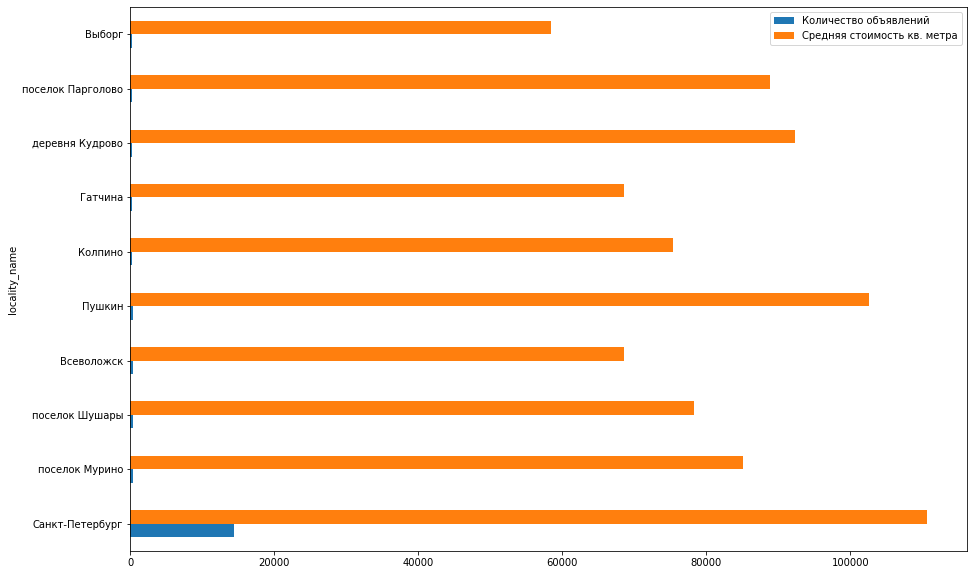

In [77]:
meter_price_by_locality = data.pivot_table(index='locality_name', values='meter_price', aggfunc=['count', 'mean'])
meter_price_by_locality.columns = ['Количество объявлений','Средняя стоимость кв. метра']
meter_price_by_locality['Средняя стоимость кв. метра'] = meter_price_by_locality['Средняя стоимость кв. метра'].round(2)
meter_price_by_locality.sort_values(by='Количество объявлений',ascending=False).head(10).plot(kind='barh',figsize=(15,10));

In [78]:
meter_price_by_locality.sort_values(by='Количество объявлений',ascending=False).head(10)

,Количество объявлений,Средняя стоимость кв. метра
locality_name,,
Санкт-Петербург,14465,110670.67
поселок Мурино,443,85095.09
поселок Шушары,429,78284.94
Всеволожск,378,68560.30
Пушкин,345,102601.55
Колпино,332,75358.15
Гатчина,298,68633.95
деревня Кудрово,282,92262.20
поселок Парголово,264,88862.07


В таблице представлены средние цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Среди этих населенных пунктов **наибольшая средняя цена квадратного метра - в Санкт-Петербурге, а наименьшая - в Выборге.**

#### Средняя цена километра (от центра города) в Санкт-Петербурге

In [79]:
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
    .sort_values('last_price', ascending=False).round(2)
)

,last_price
cityCenters_nearest_km,
1.0,11.69
0.0,11.61
2.0,11.01
5.0,10.62
4.0,10.28
7.0,10.12
6.0,9.96
3.0,9.39
8.0,8.67


В таблице представлена средняя стоимость квартир в зависимости от удаления от центра Санкт-Петербурга (по километрам). Можно сказать, что данная таблица отражает дороговизну километров от центра в порядке убывания. Самые дорогие километры - нулевой, первый и второй, а самые дешевые - 24-ый, 26-й и 25-ый.

Неожиданный рост цены на 27 километре стоит рассмотреть поближе.

In [80]:
data.query('(cityCenters_nearest_km == 27)&(locality_name=="Санкт-Петербург")')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,cityCenters_nearest,parks_nearest,ponds_nearest,days_exposition,meter_price,post_weekday,post_month,post_year,floor_type,cityCenters_nearest_km
726,13,14.35,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,27313.0,1496.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0
5781,6,2.25,32.0,2018-02-27,1,2.50,2,16.5,2,False,...,27431.0,NaN,NaN,178.0,70312.500000,1,2,2018,последний,27.0


Становится ясно, почему 27 километр так дорог! Всего 2 квартиры - нерепрезентативная выборка!

Также рассмотрим 5-й и 3-й километры.

In [81]:
data.query('((cityCenters_nearest_km == 3))&(locality_name=="Санкт-Петербург")')['floor'].value_counts()

2     61
3     55
4     53
5     53
1     48
6     13
7      2
9      1
10     1
Name: floor, dtype: int64

In [82]:
data.query('((cityCenters_nearest_km == 5))&(locality_name=="Санкт-Петербург")')['floor'].value_counts()

3     139
4     133
2     124
5     103
1      68
6      47
7      41
8      28
9      28
10     14
11      9
19      9
14      6
12      5
17      3
13      2
16      2
18      2
15      1
Name: floor, dtype: int64

На 5-ом километре, как видно, гораздо больше предложений на высоких этажах. Возможно, это делает цену километра выше.

In [83]:
# способы группировки и сортировки информации

(
    data
     .query('(3 <= cityCenters_nearest_km <= 5) & (locality_name=="Санкт-Петербург")')
     .groupby(['cityCenters_nearest_km', 'floor_type'])['last_price']
     .agg(['count', 'mean'])
     .style.format("{:,.2f}", subset=['mean'])
)

### Общий вывод

В результате исследования, было найдено **среднее количество дней до снятия объявлений с платформы - 180,7 дней**, а также **медианное значение - 95 дней**. Максимально долгие объявления находились на платформе до 1600 дней (около 4,5 лет).

Среди всех факторов, стоимость объекта **зависит от площади больше всего**. Также стоит отметить, что **квартиры на первых этажах значительно дешевле, чем другие квартиры**. Зависимость цены от дня и месяца публикации - нечто абстрактное, но вот при наблюдении графика по году публикации объявления, можно обнаружить, что **самые дорогие объекты были опубликованы в 2015 и 2019 году**, а **самые дешевые (по медиане) - в 2016 и 2017**. С 2017 по 2019 наблюдается рост медианной цены объектов.

Была посчитана **средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**. Среди этих населенных пунктов **наибольшая средняя цена квадратного метра - в Санкт-Петербурге, а наименьшая - в Выборге.**

Также была найдена **средняя стоимость объектов по километрам от центра в Санкт-Петербурге**. **Самые дорогие километры** - нулевой, первый и второй, а **самые дешевые** - 24-ый, 26-й и 25-ый.